In [1]:
import warnings
warnings.filterwarnings("ignore", message=r"Passing", category=FutureWarning)

In [2]:
import seaborn as sns
import numpy as np 
import pandas as pd 
import cv2
import matplotlib.pyplot as plt 
import os
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.optimizers import Adam
from tqdm import tqdm
import fnmatch
import re

In [3]:
df_patient_1 = pd.read_csv('./PatientData/Patient_1_Labels.csv')
df_patient_2 = pd.read_csv('./PatientData/Patient_2_Labels.csv')
df_patient_3 = pd.read_csv('./PatientData/Patient_3_Labels.csv')
df_patient_4 = pd.read_csv('./PatientData/Patient_4_Labels.csv')
df_patient_5 = pd.read_csv('./PatientData/Patient_5_Labels.csv')

df_patient_1['File'] = 'Patient_1'
df_patient_2['File'] = 'Patient_2'
df_patient_3['File'] = 'Patient_3'
df_patient_4['File'] = 'Patient_4'
df_patient_5['File'] = 'Patient_5'

## Merge the first 5 patient labels file into one Dataframe and add the corresponding Threshold image filename

In [4]:
df_merge = pd.concat([df_patient_1, df_patient_2, df_patient_3, df_patient_4, df_patient_5], ignore_index=True)
df_merge['Filename'] = 'IC_' + df_merge.IC.astype(str) + '_thresh.png'

## Changing the labels with value any greater than 0 to 1

In [5]:
df_merge.loc[df_merge["Label"] >= 1, "Label"] = 1

## Test train split

In [6]:
X_train = []
y_train = []
X_test = []
y_test = []
image_size = 150
test_set_labels = ['Patient_1', 'Patient_2', 'Patient_3', 'Patient_4', 'Patient_5']

for i in test_set_labels:
    folderPath = os.path.join('.\PatientData',i)
    for j in tqdm(os.listdir(folderPath)):
        if fnmatch.fnmatch(j, '*_thresh.png'):
            img = cv2.imread(os.path.join(folderPath,j))
            img = cv2.resize(img,(image_size, image_size))
            X_train.append(img[30:128, 0:137])        
            y_train.append(df_merge.loc[(df_merge['File'] == i) & (df_merge['Filename'] == j), 'Label'])
        
# test_folderPath = os.path.join('.\PatientData\Patient_5')
# for j in tqdm(os.listdir(test_folderPath)):
#     if fnmatch.fnmatch(j, '*_thresh.png'):
#         img = cv2.imread(os.path.join(test_folderPath,j))
#         img = cv2.resize(img,(image_size,image_size))
#         X_test.append(img)
#         y_test.append(df_patient_5.loc[(df_patient_5['File'] == 'Patient_5') & (df_patient_5['Filename'] == j), 'Label'])

s_y_train = pd.Series(y_train)
# s_y_test = pd.Series(y_test)
X_train = np.array(X_train)
y_train = s_y_train.to_numpy(dtype="int")
# X_test = np.array(X_test)
# y_test = s_y_test.to_numpy(dtype="int")

100%|██████████| 1073/1073 [00:01<00:00, 921.90it/s]


In [7]:
X_train.shape

(502, 98, 137, 3)

## Sample Images of different labels

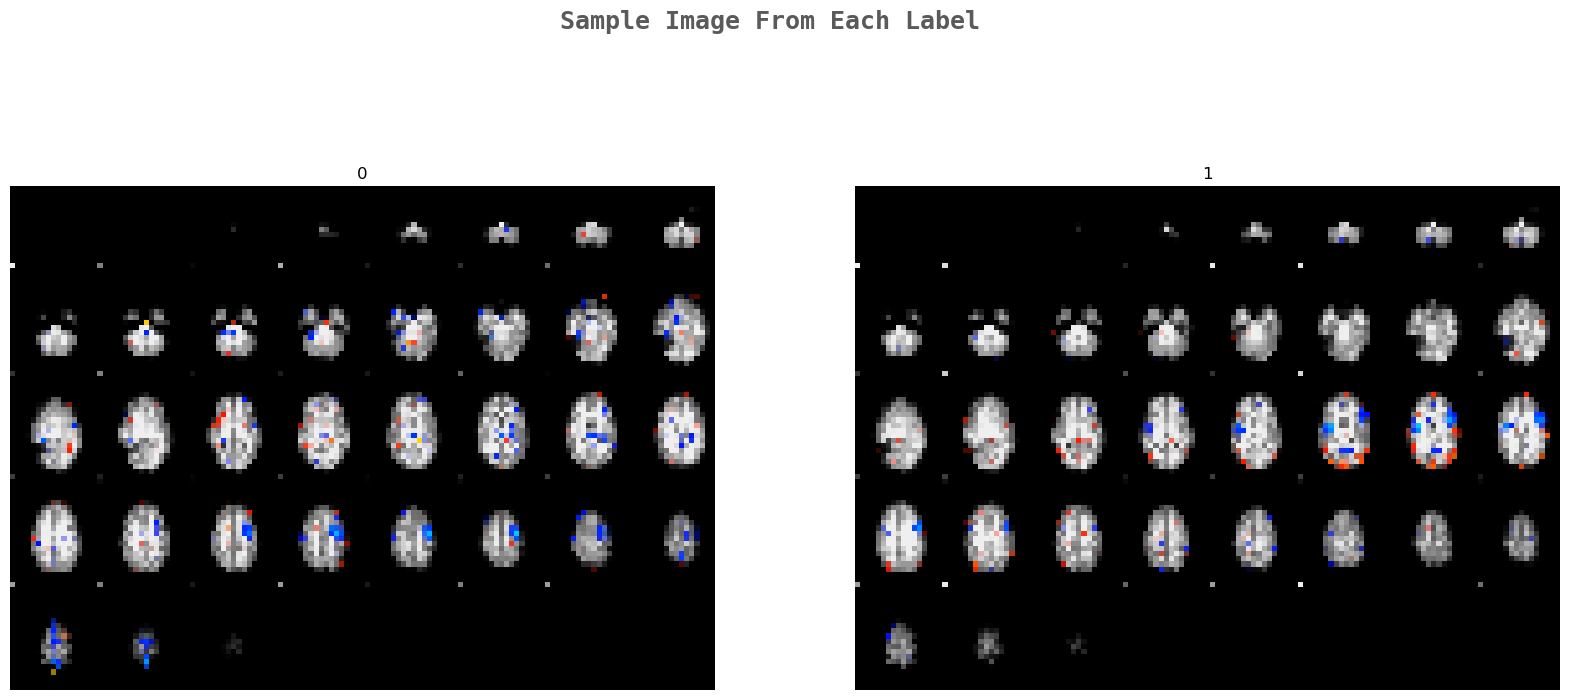

In [8]:
#This block is only for Jupyter notebook
import seaborn as sns
colors_dark = ["#1F1F1F", "#313131", '#636363', '#AEAEAE', '#DADADA']

k=0
fig, ax = plt.subplots(1,2,figsize=(20,20))
fig.text(s='Sample Image From Each Label',size=18,fontweight='bold',
             fontname='monospace',color=colors_dark[1],y=.7,x=0.4,alpha=0.8)
for i in [0, 1]:
    j=0
    while True :
        if y_train[j]==i:
            ax[k].imshow(X_train[j])
            ax[k].set_title(y_train[j])
            ax[k].axis('off')
            k+=1
            break
        j+=1

In [9]:
# #This block is only for Jupyter notebook
# import seaborn as sns
# colors_dark = ["#1F1F1F", "#313131", '#636363', '#AEAEAE', '#DADADA']

# k=0
# fig, ax = plt.subplots(1,2,figsize=(20,20))
# print(X_train[1][30:128,0:137].shape)
# ax[0].imshow(X_train[1])
# ax[0].axis('off')

# ax[1].imshow(X_train[70][30:128,0:137])
# ax[1].axis('off')

## Shuffling the training data to prevent any skewness in data

In [10]:
from sklearn.utils import shuffle
X_train, y_train = shuffle(X_train, y_train, random_state=42)

In [11]:
image_size_x, image_size_y, color_channel = X_train[0].shape

## Model Building

In [12]:
model = tf.keras.Sequential()

# Convolutional layer and maxpool layer 1
model.add(keras.layers.Conv2D(32, (3,3),activation='relu',input_shape=(image_size_x, image_size_y,3)))
model.add(keras.layers.MaxPool2D(2,2))

# Convolutional layer and maxpool layer 2
model.add(keras.layers.Conv2D(64, (3,3),activation='relu'))
model.add(keras.layers.MaxPool2D(2,2))

# Convolutional layer and maxpool layer 3
model.add(keras.layers.Conv2D(128, (3,3),activation='relu'))
model.add(keras.layers.MaxPool2D(2,2))

# Convolutional layer and maxpool layer 4
model.add(keras.layers.Conv2D(256, (3,3),activation='relu'))
model.add(keras.layers.MaxPool2D(2,2))

# Convolutional layer and maxpool layer 5
model.add(keras.layers.Conv2D(256, (3,3),activation='relu'))
model.add(keras.layers.MaxPool2D(2,2))

# This layer flattens the resulting image array to 1D array
model.add(keras.layers.Flatten())

# Hidden layer with 128 neurons and Rectified Linear Unit activation function 
model.add(keras.layers.Dense(128, activation='relu'))

# Dropout layer to prevent overfitting
model.add(keras.layers.Dropout(0.4))

# Hidden layer with 64 neurons and Rectified Linear Unit activation function 
model.add(keras.layers.Dense(64, activation='relu'))

# Dropout layer to prevent overfitting
model.add(keras.layers.Dropout(0.4))

# Output layer with single neuron predicts the probablity of the target label
#Here we use sigmoid activation function which makes our model output to lie between 0 and 1
model.add(keras.layers.Dense(1, activation='sigmoid'))

## Compiling the CNN
model.compile(loss='binary_crossentropy', optimizer="Adam", metrics=['accuracy'])

model.summary() 

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 96, 135, 32)       896       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 48, 67, 32)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 46, 65, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 23, 32, 64)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 21, 30, 128)       73856     
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 10, 15, 128)      0

In [ ]:
history = model.fit(X_train, y_train, validation_split=0.2, epochs=75, verbose=1, batch_size=32)

Epoch 1/75
13/13 [==============================] - 7s 422ms/step - loss: 8.8570 - accuracy: 0.5012 - val_loss: 0.7696 - val_accuracy: 0.5149
Epoch 2/75
13/13 [==============================] - 6s 434ms/step - loss: 0.7603 - accuracy: 0.5162 - val_loss: 0.6936 - val_accuracy: 0.4851
Epoch 3/75
13/13 [==============================] - 5s 401ms/step - loss: 0.7168 - accuracy: 0.5062 - val_loss: 0.6918 - val_accuracy: 0.5149
Epoch 4/75
13/13 [==============================] - 5s 413ms/step - loss: 0.6875 - accuracy: 0.5411 - val_loss: 0.6901 - val_accuracy: 0.5149
Epoch 5/75
13/13 [==============================] - 5s 417ms/step - loss: 0.6993 - accuracy: 0.4988 - val_loss: 0.6875 - val_accuracy: 0.5149
Epoch 6/75
13/13 [==============================] - 6s 429ms/step - loss: 0.6856 - accuracy: 0.5411 - val_loss: 0.6886 - val_accuracy: 0.5149
Epoch 7/75
13/13 [==============================] - 5s 415ms/step - loss: 0.6971 - accuracy: 0.5287 - val_loss: 0.6902 - val_accuracy: 0.5149
Epoch 